In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-rna-3d-folding/sample_submission.csv
/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv
/kaggle/input/stanford-rna-3d-folding/test_sequences.csv
/kaggle/input/stanford-rna-3d-folding/validation_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_sequences.csv


## lets do some data exploration and understand what we have here

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
# Load sequence data
train_sequences = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/train_sequences.csv")
val_sequences = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv")
test_sequences = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")

In [4]:
# Function to analyze sequence length distribution
def plot_sequence_lengths(df, title):
    lengths = df['sequence'].apply(len)
    plt.figure(figsize=(8, 5))
    sns.histplot(lengths, bins=30, kde=True)
    plt.xlabel("Sequence Length")
    plt.ylabel("Count")
    plt.title(f"Distribution of Sequence Lengths ({title})")
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


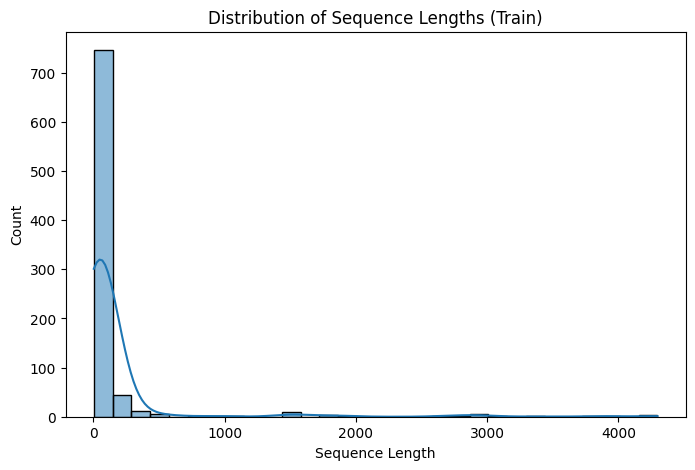

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


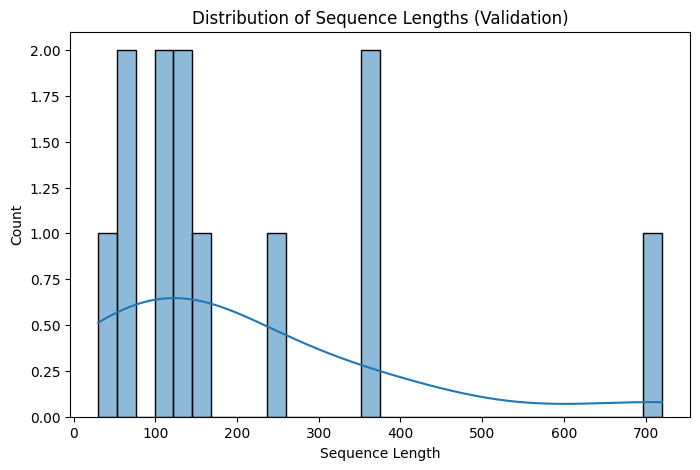

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


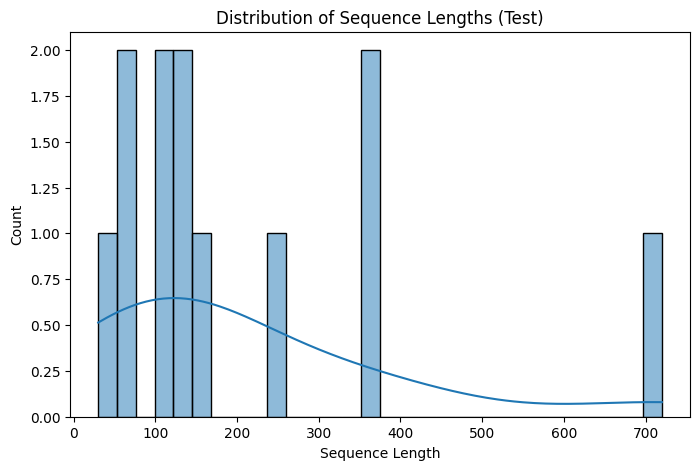

In [5]:
# Plot sequence length distributions
plot_sequence_lengths(train_sequences, "Train")
plot_sequence_lengths(val_sequences, "Validation")
plot_sequence_lengths(test_sequences, "Test")


In [6]:
# Function to analyze nucleotide composition
def nucleotide_composition(df, title):
    all_nucleotides = "".join(df['sequence'])
    counts = Counter(all_nucleotides)
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.xlabel("Nucleotide")
    plt.ylabel("Count")
    plt.title(f"Nucleotide Composition ({title})")
    plt.show()
    
    print(f"Nucleotide composition in {title}: {counts}")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


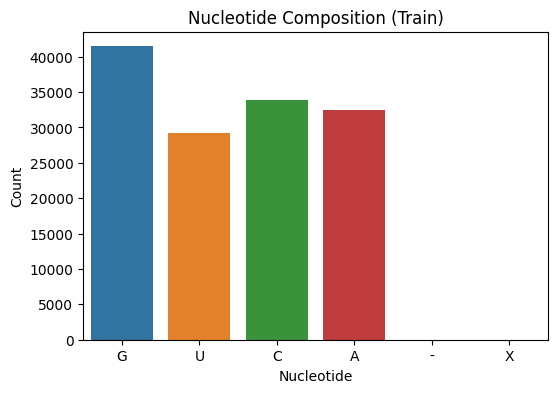

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Nucleotide composition in Train: Counter({'G': 41450, 'C': 33937, 'A': 32524, 'U': 29178, '-': 4, 'X': 2})


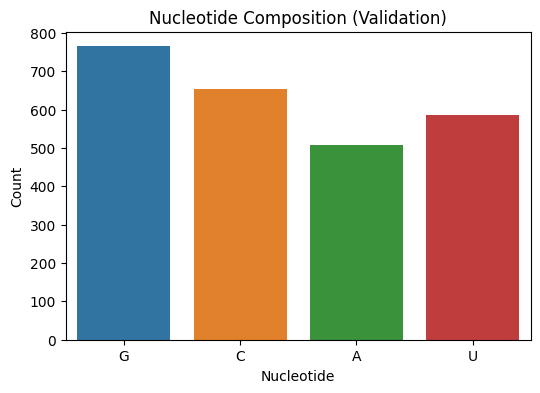

Nucleotide composition in Validation: Counter({'G': 765, 'C': 655, 'U': 586, 'A': 509})


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


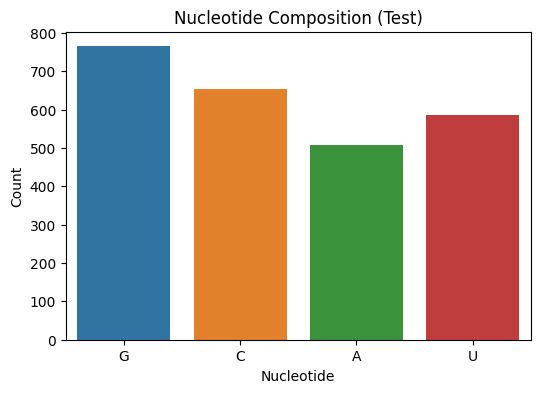

Nucleotide composition in Test: Counter({'G': 765, 'C': 655, 'U': 586, 'A': 509})


In [7]:
# Check nucleotide distribution
nucleotide_composition(train_sequences, "Train")
nucleotide_composition(val_sequences, "Validation")
nucleotide_composition(test_sequences, "Test")

In [8]:

# Check for non-ACGU characters in training set
train_sequences['non_standard'] = train_sequences['sequence'].apply(lambda x: any(c not in "ACGU" for c in x))
non_standard_count = train_sequences['non_standard'].sum()
print(f"Non-ACGU sequences in train set: {non_standard_count}")


Non-ACGU sequences in train set: 4


In [9]:

# Check for missing values
print("Missing values in datasets:")
print("Train:", train_sequences.isnull().sum().sum())
print("Validation:", val_sequences.isnull().sum().sum())
print("Test:", test_sequences.isnull().sum().sum())


Missing values in datasets:
Train: 5
Validation: 0
Test: 0


In [10]:
# Load structural label data
train_labels = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/train_labels.csv")
val_labels = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/validation_labels.csv")


In [11]:
# Extract unique target IDs
print(f"Unique target IDs in train_labels: {train_labels['ID'].apply(lambda x: x.split('_')[0]).nunique()}")
print(f"Unique target IDs in val_labels: {val_labels['ID'].apply(lambda x: x.split('_')[0]).nunique()}")


Unique target IDs in train_labels: 735
Unique target IDs in val_labels: 12


In [12]:
# Count residues per structure
train_labels['target_id'] = train_labels['ID'].apply(lambda x: x.split('_')[0])
residue_counts = train_labels.groupby('target_id').size()

In [13]:
# Count residues per structure
train_labels['target_id'] = train_labels['ID'].apply(lambda x: x.split('_')[0])
residue_counts = train_labels.groupby('target_id').size()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


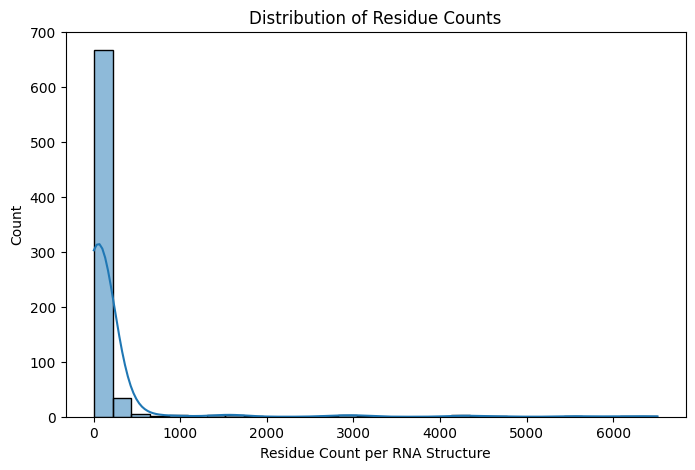

In [14]:

plt.figure(figsize=(8, 5))
sns.histplot(residue_counts, bins=30, kde=True)
plt.xlabel("Residue Count per RNA Structure")
plt.ylabel("Count")
plt.title("Distribution of Residue Counts")
plt.show()



In [15]:
# Analyze (x, y, z) coordinate distributions
coordinate_columns = [col for col in train_labels.columns if col.startswith("x_") or col.startswith("y_") or col.startswith("z_")]

train_labels[coordinate_columns].describe()


,x_1,y_1,z_1
count,130950.000000,130950.000000,130950.000000
mean,80.447315,84.040727,98.611226
std,147.422319,114.928902,119.410665
min,-821.085999,-449.414001,-333.403992
25%,-1.115750,-4.890750,2.218500
50%,62.651501,67.901501,72.938499
75%,178.809753,170.451996,184.531750
max,849.887024,889.507996,668.776978


In [16]:
# Convert temporal_cutoff to datetime
train_sequences["temporal_cutoff"] = pd.to_datetime(train_sequences["temporal_cutoff"])

# Define cutoff date
cutoff_date = pd.to_datetime("2022-05-27")

# Split data
clean_train_sequences = train_sequences[train_sequences["temporal_cutoff"] < cutoff_date]
valid_sequences = train_sequences[train_sequences["temporal_cutoff"] >= cutoff_date]

print(f"Train sequences before cutoff: {len(clean_train_sequences)}")
print(f"Validation sequences after cutoff: {len(valid_sequences)}")


Train sequences before cutoff: 692
Validation sequences after cutoff: 152


In [17]:
# Identify duplicated sequences
duplicate_counts = train_sequences.groupby("sequence")["target_id"].nunique()
duplicates = duplicate_counts[duplicate_counts > 1]

print(f"Number of duplicate sequences: {len(duplicates)}")

# Display some duplicate sequences
duplicates.head(10)

# Merge multiple available structures into additional (x_2, y_2, z_2) labels
merged_labels = train_labels.groupby("target_id").apply(lambda x: x.iloc[:, 3:].mean())

print(f"Merged labels shape: {merged_labels.shape}")


Number of duplicate sequences: 45
Merged labels shape: (735, 3)


## now lets inspect and do some cleaning 

In [18]:
train_sequences.head()


,target_id,sequence,temporal_cutoff,description,all_sequences,non_standard
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1995-01-26,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...,False
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU,1995-02-27,THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...,>1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...,False
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU,1995-06-03,24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...,>1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...,False
3,1HLX_A,GGGAUAACUUCGGUUGUCCC,1995-09-15,P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID,>1HLX_1|Chain A|RNA (5'-R(*GP*GP*GP*AP*UP*AP*A...,False
4,1HMH_E,GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU,1995-12-07,THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...,">1HMH_1|Chains A, C, E|HAMMERHEAD RIBOZYME-RNA...",False


In [19]:
train_sequences.shape

(844, 6)

In [20]:
val_sequences.head()



,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."
3,R1117v2,UUGGGUUCCCUCACCCCAAUCAUAAAAAGG,2022-06-03,PreQ1 class I type III riboswitch\nK. pneumoni...,">8FZA_1|Chains A, B|PreQ1 Riboswitch (30-MER)|..."
4,R1126,GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUU...,2022-06-11,Traptamer\nSynthetic\nAdditional Information: ...,>8TVZ_1|Chain A[auth C]|RNA (363-MER)|syntheti...


In [21]:
val_sequences.shape

(12, 5)

In [22]:
test_sequences.head()

,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."
3,R1117v2,UUGGGUUCCCUCACCCCAAUCAUAAAAAGG,2022-06-03,PreQ1 class I type III riboswitch\nK. pneumoni...,">8FZA_1|Chains A, B|PreQ1 Riboswitch (30-MER)|..."
4,R1126,GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUU...,2022-06-11,Traptamer\nSynthetic\nAdditional Information: ...,>8TVZ_1|Chain A[auth C]|RNA (363-MER)|syntheti...


In [23]:
test_sequences.shape

(12, 5)

In [24]:
# Count missing values
print("Missing values in Train:\n", train_sequences.isnull().sum())
print("Missing values in Validation:\n", val_sequences.isnull().sum())
print("Missing values in Test:\n", test_sequences.isnull().sum())




Missing values in Train:
 target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      5
non_standard       0
dtype: int64
Missing values in Validation:
 target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
dtype: int64
Missing values in Test:
 target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
dtype: int64


In [25]:
# drop rows with the missing values
train_sequences.dropna(inplace=True)  # Remove missing values

In [26]:
# Check nucleotide composition
def check_nucleotide_distribution(data, column="sequence"):
    all_nucleotides = "".join(data[column].dropna().values)  # Concatenate all sequences
    return Counter(all_nucleotides)

print("Nucleotide distribution in Train:", check_nucleotide_distribution(train_sequences))
print("Nucleotide distribution in Validation:", check_nucleotide_distribution(val_sequences))
print("Nucleotide distribution in Test:", check_nucleotide_distribution(test_sequences))



Nucleotide distribution in Train: Counter({'G': 38626, 'C': 31847, 'A': 30341, 'U': 27530, '-': 4, 'X': 2})
Nucleotide distribution in Validation: Counter({'G': 765, 'C': 655, 'U': 586, 'A': 509})
Nucleotide distribution in Test: Counter({'G': 765, 'C': 655, 'U': 586, 'A': 509})


In [27]:
# Remove sequences with invalid characters
def remove_invalid_sequences(data, column="sequence"):
    valid_chars = {'A', 'C', 'G', 'U'}
    return data[data[column].apply(lambda x: set(x).issubset(valid_chars))]

train_df = remove_invalid_sequences(train_sequences)


In [28]:
# Check for duplicates
print("Duplicate sequences in Train:", train_df.duplicated(subset=['sequence']).sum())

# Drop duplicates
train_df = train_df.drop_duplicates(subset=['sequence'])


Duplicate sequences in Train: 60


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


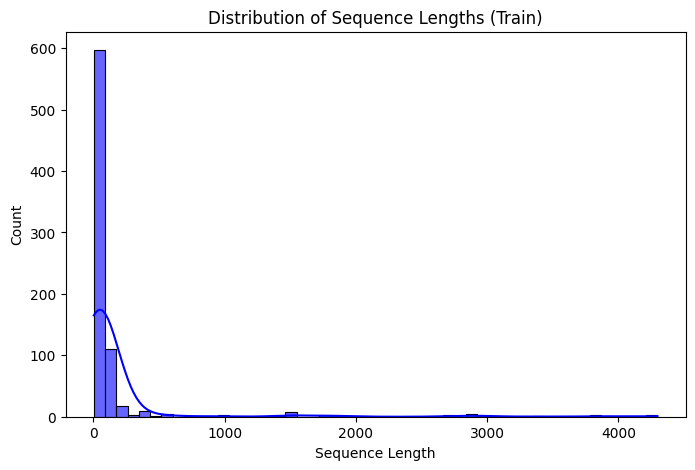

In [29]:
# Compute sequence lengths
train_df["seq_length"] = train_df["sequence"].apply(len)
val_sequences["seq_length"] = val_sequences["sequence"].apply(len)
test_sequences["seq_length"] = test_sequences["sequence"].apply(len)

# Visualize sequence length distribution
plt.figure(figsize=(8, 5))
sns.histplot(train_df["seq_length"], bins=50, kde=True, color="blue", alpha=0.6)
plt.title("Distribution of Sequence Lengths (Train)")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.show()


In [30]:
MAX_SEQ_LENGTH = 500  # Adjust based on distribution

# Function to pad or truncate sequences
def pad_or_truncate(seq, max_length=MAX_SEQ_LENGTH):
    if len(seq) > max_length:
        return seq[:max_length]  # Truncate
    else:
        return seq.ljust(max_length, 'N')  # Pad with 'N'

train_df["processed_sequence"] = train_df["sequence"].apply(lambda x: pad_or_truncate(x, MAX_SEQ_LENGTH))
val_sequences["processed_sequence"] = val_sequences["sequence"].apply(lambda x: pad_or_truncate(x, MAX_SEQ_LENGTH))
test_sequences["processed_sequence"] = test_sequences["sequence"].apply(lambda x: pad_or_truncate(x, MAX_SEQ_LENGTH))


In [31]:
# One-hot encoding function
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'U': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping[char] for char in seq])

# Apply encoding
train_df["encoded_sequence"] = train_df["processed_sequence"].apply(one_hot_encode)
val_sequences["encoded_sequence"] = val_sequences["processed_sequence"].apply(one_hot_encode)
test_sequences["encoded_sequence"] = test_sequences["processed_sequence"].apply(one_hot_encode)


In [32]:
train_df.to_csv("train_processed.csv", index=False)
val_sequences.to_csv("validation_processed.csv", index=False)
test_sequences.to_csv("test_processed.csv", index=False)

In [33]:
newtrain_df=pd.read_csv("train_processed.csv")
val_df=pd.read_csv("validation_processed.csv")
test_df=pd.read_csv("test_processed.csv")

In [34]:
# Install EternaFold dependencies (if not already installed)
!pip install Bio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.9 MB/s eta 0:00:00


In [35]:
from Bio.Seq import Seq
from Bio.SeqUtils import gc_fraction

def mock_bppm(sequence):
    """Simulate a BPPM using GC content as a placeholder (for testing)."""
    seq_len = len(sequence)
    bppm_matrix = np.random.rand(seq_len, seq_len) * gc_fraction(sequence)  # Randomized placeholder
    return bppm_matrix

# Compute BPPMs and store them as lists (not NumPy arrays)
train_bppms = [mock_bppm(seq) for seq in newtrain_df["sequence"]]
val_bppms = [mock_bppm(seq) for seq in val_df["sequence"]]
test_bppms = [mock_bppm(seq) for seq in test_df["sequence"]]

# Save each BPPM separately
import pickle
with open("train_bppm.pkl", "wb") as f:
    pickle.dump(train_bppms, f)

with open("val_bppm.pkl", "wb") as f:
    pickle.dump(val_bppms, f)

with open("test_bppm.pkl", "wb") as f:
    pickle.dump(test_bppms, f)

print("BPPM computation complete! Saved as .pkl files.")


BPPM computation complete! Saved as .pkl files.


## training the model

In [36]:
! pip install Network

  Preparing metadata (setup.py) ... done
  Created wheel for Network: filename=network-0.1-py3-none-any.whl size=3138 sha256=baffe351bd10331686d42d227921eb8fc843c246129296b378c09649475a1b6e
  Stored in directory: /root/.cache/pip/wheels/25/97/b1/563d3a70ed8f588bf9cf448f079024a9751b54d15a0ce3d46b
Successfully built Network


In [37]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from transformers import get_cosine_schedule_with_warmup
# from Network import *  # Ensure the correct import
# # --------------------
# # Load Processed Data
# # --------------------
# train_df = pd.read_csv("train_processed.csv")
# val_df = pd.read_csv("validation_processed.csv")
# test_df = pd.read_csv("test_processed.csv")

# # Assuming BPPMs are precomputed and stored
# train_bppm = np.load("train_bppm.npy")  # Shape (num_samples, seq_len, seq_len)
# val_bppm = np.load("val_bppm.npy")
# test_bppm = np.load("test_bppm.npy")

# # --------------------
# # Custom Dataset Loader
# # --------------------
# class RNADataset(Dataset):
#     def __init__(self, sequences, bppms, labels=None):
#         self.sequences = sequences
#         self.bppms = bppms
#         self.labels = labels
    
#     def __len__(self):
#         return len(self.sequences)
    
#     def __getitem__(self, idx):
#         seq = self.sequences[idx]
#         bppm = self.bppms[idx]
#         if self.labels is not None:
#             label = self.labels[idx]
#             return torch.tensor(seq, dtype=torch.long), torch.tensor(bppm, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
#         return torch.tensor(seq, dtype=torch.long), torch.tensor(bppm, dtype=torch.float32)

# # Create DataLoaders
# train_dataset = RNADataset(train_df["encoded_sequence"].values, train_bppm, train_df["labels"].values)
# val_dataset = RNADataset(val_df["encoded_sequence"].values, val_bppm, val_df["labels"].values)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# # --------------------
# # Model Setup & Training
# # --------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = RiboNanzaNet().to(device)  # Load Pretrained Model

# # Modify Model: Add Dynamic Positional Encoding & SE-CNN
# model.enable_dynamic_positional_encoding()
# model.add_se_cnn_block()

# optimizer = optim.AdamW(model.parameters(), lr=2.5e-3, weight_decay=0.05)
# scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=270*1791)

# criterion = nn.MSELoss()

# # Training Loop
# for epoch in range(270):
#     model.train()
#     total_loss = 0
#     for seqs, bppms, labels in train_loader:
#         seqs, bppms, labels = seqs.to(device), bppms.to(device), labels.to(device)
#         optimizer.zero_grad()
#         preds = model(seqs, bppms)
#         loss = criterion(preds, labels)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader)}")

# # Save Model
# torch.save(model.state_dict(), "ribonanza_finetuned.pth")
